In [9]:
import pandas as pd
from scipy import stats
from sklearn.metrics import make_scorer
from asodesigner.consts import *
from asodesigner.file_utils import read_human_genome_fasta_dict

all_data = pd.read_csv(DATA_PATH / 'data_from_article_fixed.csv')

In [10]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr

# Compute GC content from the Sequence
def compute_gc(seq):
    seq = seq.upper()
    gc_count = seq.count('G') + seq.count('C')
    return gc_count / len(seq) if len(seq) > 0 else 0

all_data = all_data.dropna(subset=['Inhibition(%)', 'Sequence'])

all_data['GC_content'] = all_data['Sequence'].apply(compute_gc)

# Prepare features and target
X = all_data[['GC_content']]
y = all_data['Inhibition(%)']


# Fit a linear regression model
model = LinearRegression()
model.fit(X, y)
all_data['Predicted'] = model.predict(X)

# Show head of results
print(all_data[['Cell_line', 'ISIS', 'Sequence', 'GC_content', 'Inhibition(%)']].head())

# Spearman correlation
rho, pval = spearmanr(all_data['GC_content'], all_data['Inhibition(%)'])
print(f"\nSpearman correlation (GC content vs inhibition): {rho:.4f}, p-value: {pval:.4e}")

all_data = all_data[(all_data['Inhibition(%)'] > -100) & (all_data['Inhibition(%)'] < 150)]


  Cell_line    ISIS          Sequence  GC_content  Inhibition(%)
0      A431  540733  GCTAAAACAAATGCTA      0.3125           33.0
1      A431  540747  TATAATGGTGAATATC      0.2500            7.0
2      A431  540806  GCATGAAGATTTCTGG      0.4375           62.0
3      A431  651479  GGTGAATATCTTCAAA      0.3125           28.0
4      A431  651490  CACTTGTACTAGTATG      0.3750           36.0

Spearman correlation (GC content vs inhibition): -0.0542, p-value: 5.0775e-24


In [11]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import make_pipeline
# from sklearn.metrics import mean_squared_error, r2_score
# from xgboost import XGBRegressor


# # Define features and target
# X = all_data[['Cell_line', 'GC_content']]
# y = all_data['Inhibition(%)']

# # Preprocessing
# preprocessor = ColumnTransformer([
#     ('cat', OneHotEncoder(handle_unknown='ignore'), ['Cell_line']),
#     ('num', StandardScaler(), ['GC_content'])
# ])

# # GBoost pipeline
# pipeline = make_pipeline(preprocessor, XGBRegressor(n_estimators=100, random_state=42))

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Fit model
# pipeline.fit(X_train, y_train)

# # Predict and evaluate
# y_pred = pipeline.predict(X_test)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# r2 = r2_score(y_test, y_pred)

# print(f"XGBoost Model Performance:")
# print(f"RMSE: {rmse:.2f}")
# print(f"R²: {r2:.4f}")

In [21]:
import pandas as pd
import numpy as np
from xgboost import XGBRanker
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score

# Load and clean data
all_data = all_data.dropna(subset=["Sequence", "Inhibition(%)", "Cell_line"])

# Compute GC content
def compute_gc(seq):
    seq = seq.upper()
    return (seq.count('G') + seq.count('C')) / len(seq) if len(seq) > 0 else 0

all_data['GC_content'] = all_data['Sequence'].apply(compute_gc)

# Group by Cell_line
all_data = all_data.sort_values('Cell_line')  # important for group indexing
groups = all_data.groupby("Cell_line").size().values.tolist()

# Prepare features and target
X = all_data[['GC_content']].values
y = all_data['Inhibition(%)'].values

# Train/test split by group (leave 20% of cell lines out)
cell_lines = all_data['Cell_line'].unique()
train_lines, test_lines = train_test_split(cell_lines, test_size=0.2, random_state=42)

train_mask = all_data['Cell_line'].isin(train_lines)
test_mask = ~train_mask

X_train = all_data.loc[train_mask, ['GC_content']].values
y_train = all_data.loc[train_mask, 'Inhibition(%)'].values
group_train = all_data.loc[train_mask].groupby('Cell_line').size().values.tolist()

X_test = all_data.loc[test_mask, ['GC_content']].values
y_test = all_data.loc[test_mask, 'Inhibition(%)'].values
group_test = all_data.loc[test_mask].groupby('Cell_line').size().values.tolist()

# Train XGBRanker
ranker = XGBRanker(
    objective='rank:pairwise',
    learning_rate=0.1,
    n_estimators=100,
    random_state=42
)
ranker.fit(X_train, y_train, group=group_train)

# Predict and evaluate using NDCG (ranking quality)
start = 0
ndcg_scores = []
for g in group_test:
    end = start + g
    true_relevance = y_test[start:end].reshape(1, -1)
    scores = ranker.predict(X_test[start:end]).reshape(1, -1)
    ndcg = ndcg_score(true_relevance, scores)
    ndcg_scores.append(ndcg)
    start = end

print(f"Mean NDCG@all (ranking quality across cell lines): {np.mean(ndcg_scores):.4f}")


Mean NDCG@all (ranking quality across cell lines): 0.8764


In [22]:
def compute_ndcg_p_value(y_test, group_test, model_scores, n_permutations=1000):
    from sklearn.metrics import ndcg_score

    observed = []
    start = 0
    for g in group_test:
        end = start + g
        true_relevance = y_test[start:end]
        pred_scores = model_scores[start:end]
        ndcg = ndcg_score([true_relevance], [pred_scores])
        observed.append(ndcg)
        start = end

    model_ndcg = np.mean(observed)

    # Null distribution
    null_scores = []
    start = 0
    for _ in range(n_permutations):
        permuted_ndcgs = []
        start = 0
        for g in group_test:
            end = start + g
            true_relevance = y_test[start:end]
            permuted = np.random.permutation(true_relevance)
            ndcg = ndcg_score([true_relevance], [permuted])
            permuted_ndcgs.append(ndcg)
            start = end
        null_scores.append(np.mean(permuted_ndcgs))

    null_scores = np.array(null_scores)
    p_val = np.mean(null_scores >= model_ndcg)
    return model_ndcg, p_val

model_ndcg, pval = compute_ndcg_p_value(y_test, group_test, ranker.predict(X_test), n_permutations=1000)

print(f"Model NDCG: {model_ndcg:.4f}, p-value: {pval:.4e}")


Model NDCG: 0.8764, p-value: 7.7500e-01


=== ASO Efficacy Ranking Pipeline ===
Prepared data: 33090 samples, 11 groups
Features: ['gc_content']
Train: 22856 samples, 8 groups
Test: 10234 samples, 3 groups
Training XGBoost ranker...
Evaluating model...


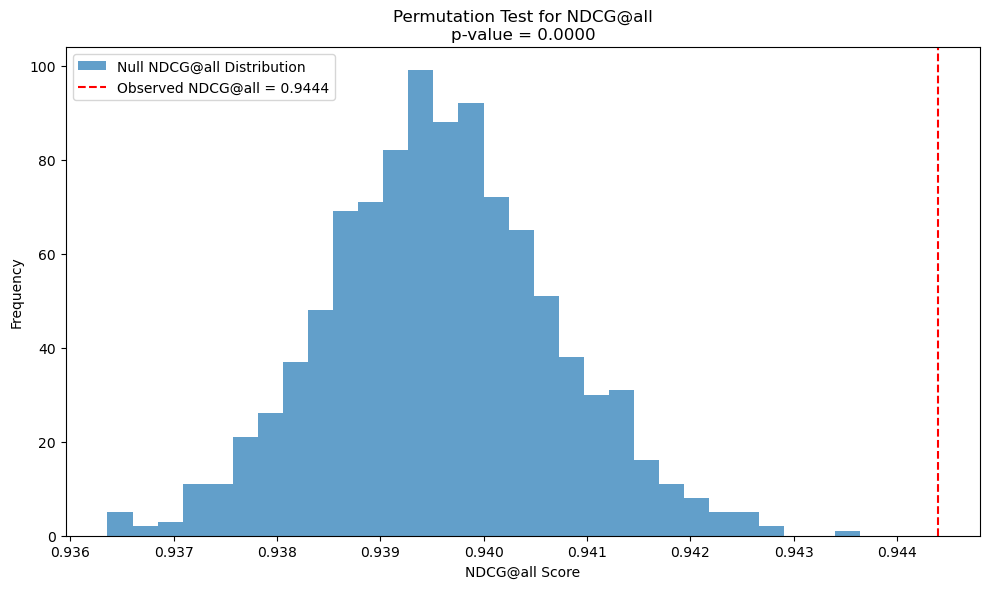

Running diagnostics...


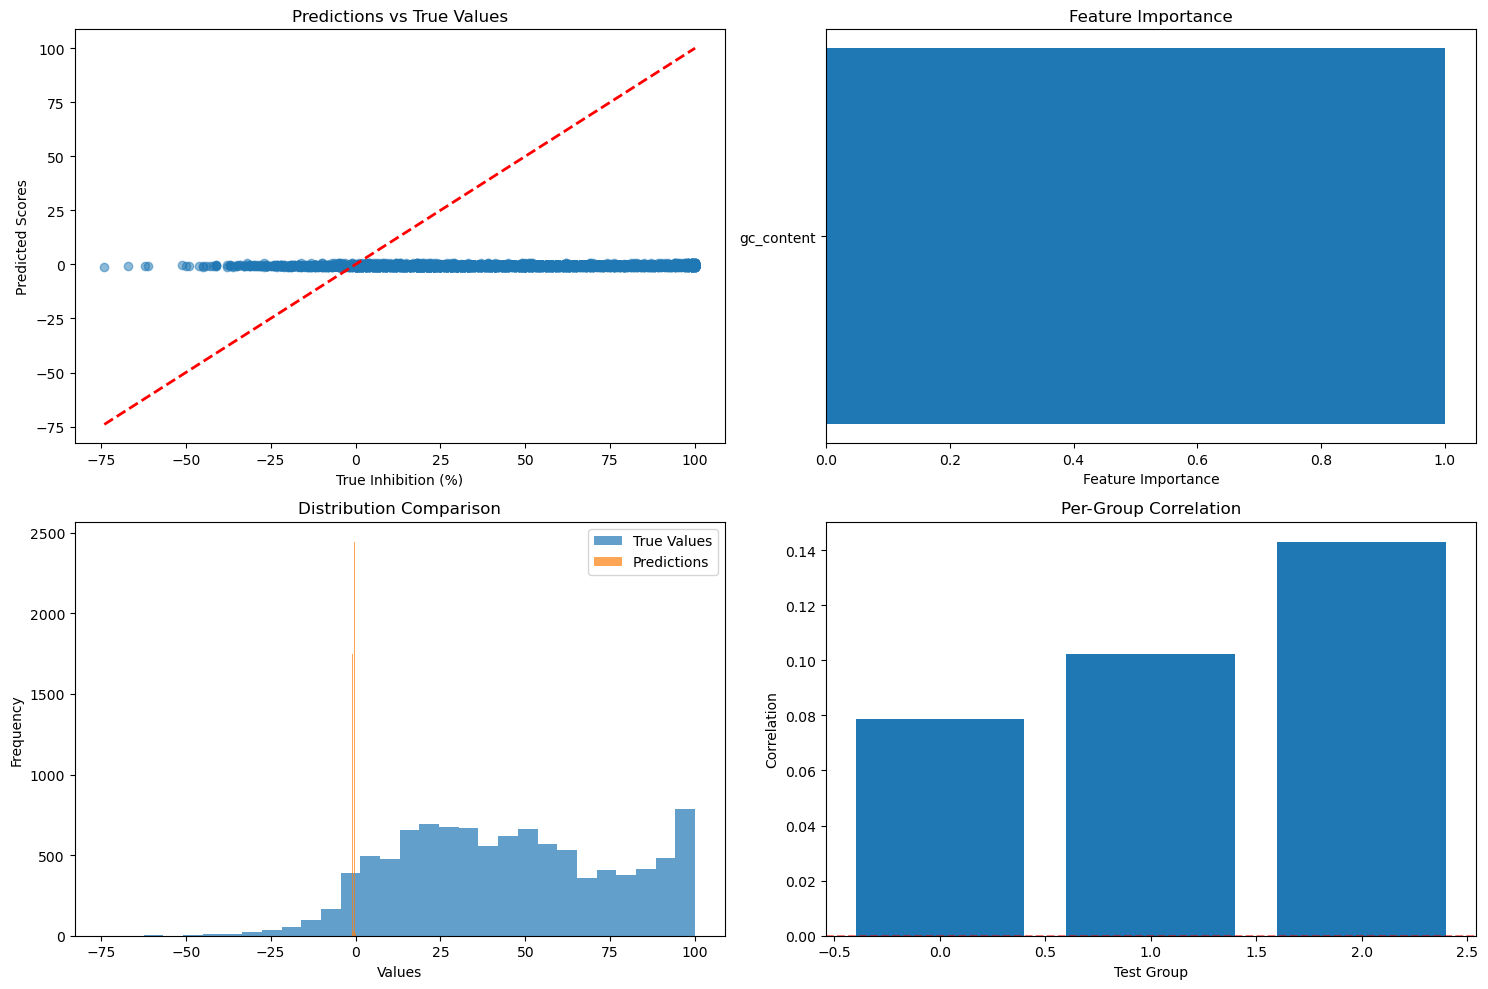


=== Results ===
NDCG_ALL: 0.9444
NDCG_5: 0.5895
NDCG_10: 0.5901
PRECISION_1: 0.0000
PRECISION_5: 0.0000
MAP_10: 0.6160
Permutation test p-value: 0.0000

Overall correlation: 0.1267
Feature importance:
  gc_content: 1.0000


In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRanker
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional, Dict, Any
import warnings
warnings.filterwarnings('ignore')


class ASOFeatureExtractor:
    """Extract features from ASO sequences."""
    
    @staticmethod
    def compute_gc_content(seq: str) -> float:
        """Compute GC content of a sequence."""
        seq = seq.upper()
        return (seq.count('G') + seq.count('C')) / len(seq) if len(seq) > 0 else 0
    
    @staticmethod
    def compute_sequence_length(seq: str) -> int:
        """Compute sequence length."""
        return len(seq)
    

    
    def extract_features(self, sequences: pd.Series, feature_names: List[str]) -> pd.DataFrame:
        """Extract specified features from sequences."""
        features = pd.DataFrame()
        
        feature_map = {
            'gc_content': self.compute_gc_content,
            'sequence_length': self.compute_sequence_length
        }
        
        for feature_name in feature_names:
            if feature_name in feature_map:
                features[feature_name] = sequences.apply(feature_map[feature_name])
            else:
                raise ValueError(f"Unknown feature: {feature_name}")
        
        return features


class RankingEvaluator:
    """Evaluate ranking model performance with multiple metrics."""
    
    @staticmethod
    def compute_ndcg_at_k(y_true: np.ndarray, y_scores: np.ndarray, 
                         group_sizes: List[int], k: Optional[int] = None) -> float:
        """Compute NDCG@k for grouped predictions."""
        ndcgs = []
        start = 0
        
        for group_size in group_sizes:
            end = start + group_size
            if group_size < 2:
                start = end
                continue
                
            true_scores = y_true[start:end]
            pred_scores = y_scores[start:end]
            
            # Ensure non-negative relevance scores for NDCG
            if np.min(true_scores) < 0:
                true_scores = true_scores - np.min(true_scores)
            
            ndcg = ndcg_score([true_scores], [pred_scores], k=k)
            ndcgs.append(ndcg)
            start = end
        
        return np.mean(ndcgs) if ndcgs else 0.0
    
    @staticmethod
    def compute_precision_at_k(y_true: np.ndarray, y_scores: np.ndarray, 
                              group_sizes: List[int], k: int = 1) -> float:
        """Compute Precision@k for grouped predictions."""
        precisions = []
        start = 0
        
        for group_size in group_sizes:
            end = start + group_size
            if group_size < k:
                start = end
                continue
            
            true_scores = y_true[start:end]
            pred_scores = y_scores[start:end]
            
            # Get top-k predictions (highest predicted scores)
            top_k_pred_indices = np.argsort(pred_scores)[-k:]
            # Get top-k ground truth (highest true scores)
            top_k_true_indices = np.argsort(true_scores)[-k:]
            
            # Calculate precision@k
            intersection = len(set(top_k_pred_indices) & set(top_k_true_indices))
            precision = intersection / k
            precisions.append(precision)
            start = end
        
        return np.mean(precisions) if precisions else 0.0
    
    @staticmethod
    def compute_map_at_k(y_true: np.ndarray, y_scores: np.ndarray, 
                        group_sizes: List[int], k: int = 10) -> float:
        """Compute Mean Average Precision@k for grouped predictions."""
        maps = []
        start = 0
        
        for group_size in group_sizes:
            end = start + group_size
            if group_size < 2:
                start = end
                continue
            
            true_scores = y_true[start:end]
            pred_scores = y_scores[start:end]
            
            # Sort by predicted scores (descending)
            sorted_indices = np.argsort(pred_scores)[::-1]
            sorted_true = true_scores[sorted_indices]
            
            # Calculate AP@k
            relevant_positions = []
            threshold = np.percentile(true_scores, 75)  # Top 25% as relevant
            
            for i, score in enumerate(sorted_true[:k]):
                if score >= threshold:
                    relevant_positions.append(i + 1)
            
            if relevant_positions:
                ap = np.mean([len([p for p in relevant_positions if p <= pos]) / pos 
                             for pos in relevant_positions])
                maps.append(ap)
            
            start = end
        
        return np.mean(maps) if maps else 0.0
    
    def evaluate_model(self, y_true: np.ndarray, y_scores: np.ndarray, 
                      group_sizes: List[int]) -> Dict[str, float]:
        """Compute multiple evaluation metrics."""
        metrics = {
            'ndcg_all': self.compute_ndcg_at_k(y_true, y_scores, group_sizes),
            'ndcg_5': self.compute_ndcg_at_k(y_true, y_scores, group_sizes, k=5),
            'ndcg_10': self.compute_ndcg_at_k(y_true, y_scores, group_sizes, k=10),
            'precision_1': self.compute_precision_at_k(y_true, y_scores, group_sizes, k=1),
            'precision_5': self.compute_precision_at_k(y_true, y_scores, group_sizes, k=5),
            'map_10': self.compute_map_at_k(y_true, y_scores, group_sizes, k=10)
        }
        return metrics


class PermutationTester:
    """Perform permutation tests for ranking evaluation."""
    
    def __init__(self, n_permutations: int = 1000, random_state: int = 42):
        self.n_permutations = n_permutations
        self.random_state = random_state
        
    def permutation_test(self, y_true: np.ndarray, y_scores: np.ndarray, 
                        group_sizes: List[int], metric_func, **metric_kwargs) -> Tuple[float, float]:
        """Perform permutation test for a given metric."""
        np.random.seed(self.random_state)
        
        # Compute observed metric
        observed_metric = metric_func(y_true, y_scores, group_sizes, **metric_kwargs)
        
        # Generate null distribution
        null_metrics = []
        for _ in range(self.n_permutations):
            start = 0
            group_null_metrics = []
            
            for group_size in group_sizes:
                end = start + group_size
                if group_size < 2:
                    start = end
                    continue
                
                # Randomly permute predictions within group
                permuted_scores = np.random.permutation(y_scores[start:end])
                group_metric = metric_func(
                    y_true[start:end], permuted_scores, [group_size], **metric_kwargs
                )
                group_null_metrics.append(group_metric)
                start = end
            
            null_metrics.append(np.mean(group_null_metrics) if group_null_metrics else 0.0)
        
        # Compute p-value
        p_value = np.mean(np.array(null_metrics) >= observed_metric)
        return observed_metric, p_value
    
    def plot_permutation_test(self, y_true: np.ndarray, y_scores: np.ndarray, 
                             group_sizes: List[int], metric_name: str = 'NDCG@all',
                             evaluator: Optional[RankingEvaluator] = None) -> Tuple[float, float]:
        """Plot permutation test results."""
        if evaluator is None:
            evaluator = RankingEvaluator()
        
        # Select metric function
        metric_func = evaluator.compute_ndcg_at_k
        metric_kwargs = {}
        
        if metric_name == 'NDCG@5':
            metric_kwargs = {'k': 5}
        elif metric_name == 'NDCG@10':
            metric_kwargs = {'k': 10}
        elif metric_name == 'Precision@1':
            metric_func = evaluator.compute_precision_at_k
            metric_kwargs = {'k': 1}
        elif metric_name == 'MAP@10':
            metric_func = evaluator.compute_map_at_k
            metric_kwargs = {'k': 10}
        
        observed_metric, p_value = self.permutation_test(
            y_true, y_scores, group_sizes, metric_func, **metric_kwargs
        )
        
        # Generate null distribution for plotting
        np.random.seed(self.random_state)
        null_metrics = []
        for _ in range(self.n_permutations):
            start = 0
            group_null_metrics = []
            
            for group_size in group_sizes:
                end = start + group_size
                if group_size < 2:
                    start = end
                    continue
                
                permuted_scores = np.random.permutation(y_scores[start:end])
                group_metric = metric_func(
                    y_true[start:end], permuted_scores, [group_size], **metric_kwargs
                )
                group_null_metrics.append(group_metric)
                start = end
            
            null_metrics.append(np.mean(group_null_metrics) if group_null_metrics else 0.0)
        
        # Plot results
        plt.figure(figsize=(10, 6))
        plt.hist(null_metrics, bins=30, alpha=0.7, label=f'Null {metric_name} Distribution')
        plt.axvline(observed_metric, color='red', linestyle='--', 
                   label=f'Observed {metric_name} = {observed_metric:.4f}')
        plt.title(f'Permutation Test for {metric_name}\np-value = {p_value:.4f}')
        plt.xlabel(f'{metric_name} Score')
        plt.ylabel('Frequency')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        return observed_metric, p_value


class ASOEfficacyRanker:
    """Main class for ASO efficacy ranking pipeline."""
    
    def __init__(self, groupby_col: str = 'Cell_line', 
                 feature_cols: Optional[List[str]] = None,
                 min_group_size: int = 500,
                 test_size: float = 0.2,
                 random_state: int = 42,
                 stratified_split: bool = True):
        self.groupby_col = groupby_col
        self.feature_cols = feature_cols or ['gc_content']
        self.min_group_size = min_group_size
        self.test_size = test_size
        self.random_state = random_state
        self.stratified_split = stratified_split
        
        self.feature_extractor = ASOFeatureExtractor()
        self.evaluator = RankingEvaluator()
        self.permutation_tester = PermutationTester(random_state=random_state)
        self.ranker = None
        
    def prepare_data(self, data: pd.DataFrame) -> Tuple[pd.DataFrame, np.ndarray, np.ndarray, pd.Series]:
        """Prepare data for training."""
        # Clean data
        data = data.dropna(subset=["Sequence", "Inhibition(%)", self.groupby_col])
        
        # Extract features
        sequence_features = self.feature_extractor.extract_features(
            data['Sequence'], self.feature_cols
        )
        
        # Add features to dataframe
        for col in sequence_features.columns:
            data[col] = sequence_features[col]
        
        # Filter groups with sufficient samples
        group_counts = data[self.groupby_col].value_counts()
        valid_groups = group_counts[group_counts >= self.min_group_size].index
        data = data[data[self.groupby_col].isin(valid_groups)]
        
        if len(data) == 0:
            raise ValueError(f"No groups with >= {self.min_group_size} samples found")
        
        # Sort by group for consistent ordering
        data = data.sort_values(self.groupby_col).reset_index(drop=True)
        
        # Extract features and targets
        X = data[self.feature_cols].values
        y = data['Inhibition(%)'].values
        groups = data[self.groupby_col]
        
        print(f"Prepared data: {len(data)} samples, {len(valid_groups)} groups")
        print(f"Features: {self.feature_cols}")
        
        return data, X, y, groups
    
    def split_data(self, X: np.ndarray, y: np.ndarray, 
                   groups: pd.Series) -> Tuple[np.ndarray, np.ndarray, List[int], 
                                             np.ndarray, np.ndarray, List[int]]:
        """Split data by groups with optional stratification."""
        unique_groups = groups.unique()
        
        if len(unique_groups) < 4:
            print(f"WARNING: Only {len(unique_groups)} groups available. Consider reducing test_size or min_group_size.")
        
        if self.stratified_split and len(unique_groups) >= 4:
            # Stratify by group size to ensure balanced test set
            group_sizes = groups.value_counts().loc[unique_groups]
            size_bins = pd.qcut(group_sizes, q=min(3, len(unique_groups)//2), labels=False, duplicates='drop')
            
            train_groups, test_groups = train_test_split(
                unique_groups, test_size=self.test_size, 
                random_state=self.random_state, stratify=size_bins
            )
        else:
            train_groups, test_groups = train_test_split(
                unique_groups, test_size=self.test_size, random_state=self.random_state
            )
        
        train_mask = groups.isin(train_groups)
        test_mask = ~train_mask
        
        X_train, y_train = X[train_mask], y[train_mask]
        X_test, y_test = X[test_mask], y[test_mask]
        
        # Get group sizes for training and testing
        train_group_sizes = groups[train_mask].value_counts().loc[train_groups].values.tolist()
        test_group_sizes = groups[test_mask].value_counts().loc[test_groups].values.tolist()
        
        print(f"Train: {len(X_train)} samples, {len(train_groups)} groups")
        print(f"Test: {len(X_test)} samples, {len(test_groups)} groups")
        
        if len(test_groups) < 3:
            print("WARNING: Very few test groups. Results may not be reliable.")
        
        return X_train, y_train, train_group_sizes, X_test, y_test, test_group_sizes
    
    def train_model(self, X_train: np.ndarray, y_train: np.ndarray, 
                   train_group_sizes: List[int], **xgb_params) -> XGBRanker:
        """Train XGBoost ranking model."""
        default_params = {
            'objective': 'rank:pairwise',
            'learning_rate': 0.1,
            'n_estimators': 100,
            'random_state': self.random_state
        }
        default_params.update(xgb_params)
        
        self.ranker = XGBRanker(**default_params)
        self.ranker.fit(X_train, y_train, group=train_group_sizes)
        
        return self.ranker
    
    def diagnose_model_performance(self, X_test: np.ndarray, y_test: np.ndarray, 
                                 test_group_sizes: List[int]) -> Dict[str, Any]:
        """Diagnose why model might be performing poorly."""
        if self.ranker is None:
            raise ValueError("Model not trained yet")
        
        y_scores = self.ranker.predict(X_test)
        
        diagnostics = {}
        
        # Check feature importance
        if hasattr(self.ranker, 'feature_importances_'):
            diagnostics['feature_importance'] = dict(zip(
                self.feature_cols, self.ranker.feature_importances_
            ))
        
        # Analyze predictions vs true values
        start = 0
        group_stats = []
        
        for i, group_size in enumerate(test_group_sizes):
            end = start + group_size
            true_vals = y_test[start:end]
            pred_vals = y_scores[start:end]
            
            group_stat = {
                'group_id': i,
                'group_size': group_size,
                'true_mean': np.mean(true_vals),
                'true_std': np.std(true_vals),
                'true_range': np.max(true_vals) - np.min(true_vals),
                'pred_mean': np.mean(pred_vals),
                'pred_std': np.std(pred_vals),
                'pred_range': np.max(pred_vals) - np.min(pred_vals),
                'correlation': np.corrcoef(true_vals, pred_vals)[0, 1] if len(true_vals) > 1 else 0,
                'top1_correct': np.argmax(pred_vals) == np.argmax(true_vals),
                'top5_overlap': len(set(np.argsort(pred_vals)[-5:]) & set(np.argsort(true_vals)[-5:])) if group_size >= 5 else 0
            }
            group_stats.append(group_stat)
            start = end
        
        diagnostics['group_statistics'] = group_stats
        diagnostics['overall_correlation'] = np.corrcoef(y_test, y_scores)[0, 1]
        
        return diagnostics
    
    def plot_diagnostic_plots(self, X_test: np.ndarray, y_test: np.ndarray, 
                            test_group_sizes: List[int]):
        """Create diagnostic plots."""
        if self.ranker is None:
            raise ValueError("Model not trained yet")
        
        y_scores = self.ranker.predict(X_test)
        
        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # 1. Predictions vs True Values
        axes[0, 0].scatter(y_test, y_scores, alpha=0.5)
        axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        axes[0, 0].set_xlabel('True Inhibition (%)')
        axes[0, 0].set_ylabel('Predicted Scores')
        axes[0, 0].set_title('Predictions vs True Values')
        
        # # 2. Feature Importance
        # if hasattr(self.ranker, 'feature_importances_'):
        #     importance = self.ranker.feature_importances_
        #     axes[0, 1].barh(self.feature_cols, importance)
        #     axes[0, 1].set_xlabel('Feature Importance')
        #     axes[0, 1].set_title('Feature Importance')
        # else:
        #     axes[0, 1].text(0.5, 0.5, 'Feature importance\nnot available', 
        #                    ha='center', va='center', transform=axes[0, 1].transAxes)
        #     axes[0, 1].set_title('Feature Importance')
        
        # 3. Distribution of true values
        axes[1, 0].hist(y_test, bins=30, alpha=0.7, label='True Values')
        axes[1, 0].hist(y_scores, bins=30, alpha=0.7, label='Predictions')
        axes[1, 0].set_xlabel('Values')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].set_title('Distribution Comparison')
        axes[1, 0].legend()
        
        # 4. Per-group correlation
        start = 0
        group_corrs = []
        for group_size in test_group_sizes:
            end = start + group_size
            if group_size > 1:
                corr = np.corrcoef(y_test[start:end], y_scores[start:end])[0, 1]
                group_corrs.append(corr if not np.isnan(corr) else 0)
            start = end
        
        if group_corrs:
            axes[1, 1].bar(range(len(group_corrs)), group_corrs)
            axes[1, 1].set_xlabel('Test Group')
            axes[1, 1].set_ylabel('Correlation')
            axes[1, 1].set_title('Per-Group Correlation')
            axes[1, 1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
        else:
            axes[1, 1].text(0.5, 0.5, 'No correlation data\navailable', 
                           ha='center', va='center', transform=axes[1, 1].transAxes)
            axes[1, 1].set_title('Per-Group Correlation')
        
        plt.tight_layout()
        plt.show()
    
    def evaluate_and_test(self, X_test: np.ndarray, y_test: np.ndarray, 
                         test_group_sizes: List[int], 
                         plot_permutation: bool = True) -> Dict[str, Any]:
        """Evaluate model and perform permutation tests."""
        if self.ranker is None:
            raise ValueError("Model not trained yet")
        
        # Get predictions
        y_scores = self.ranker.predict(X_test)
        
        # Compute evaluation metrics
        metrics = self.evaluator.evaluate_model(y_test, y_scores, test_group_sizes)
        
        # Perform permutation test for main metric
        main_metric, p_value = self.permutation_tester.permutation_test(
            y_test, y_scores, test_group_sizes, 
            self.evaluator.compute_ndcg_at_k
        )
        
        # Plot permutation test if requested
        if plot_permutation:
            self.permutation_tester.plot_permutation_test(
                y_test, y_scores, test_group_sizes, 'NDCG@all', self.evaluator
            )
        
        results = {
            'metrics': metrics,
            'permutation_p_value': p_value,
            'model': self.ranker
        }
        
        return results
    
    def run_pipeline(self, data: pd.DataFrame, plot_permutation: bool = True, 
                    run_diagnostics: bool = True, **xgb_params) -> Dict[str, Any]:
        """Run complete pipeline."""
        print("=== ASO Efficacy Ranking Pipeline ===")
        
        # Prepare data
        processed_data, X, y, groups = self.prepare_data(data)
        
        # Split data
        X_train, y_train, train_groups, X_test, y_test, test_groups = self.split_data(X, y, groups)
        
        # Train model
        print("Training XGBoost ranker...")
        self.train_model(X_train, y_train, train_groups, **xgb_params)
        
        # Evaluate model
        print("Evaluating model...")
        results = self.evaluate_and_test(X_test, y_test, test_groups, plot_permutation)
        
        # Run diagnostics
        if run_diagnostics:
            print("Running diagnostics...")
            diagnostics = self.diagnose_model_performance(X_test, y_test, test_groups)
            results['diagnostics'] = diagnostics
            self.plot_diagnostic_plots(X_test, y_test, test_groups)
        
        # Print results
        print("\n=== Results ===")
        for metric, value in results['metrics'].items():
            print(f"{metric.upper()}: {value:.4f}")
        print(f"Permutation test p-value: {results['permutation_p_value']:.4f}")
        
        if run_diagnostics and 'diagnostics' in results:
            print(f"\nOverall correlation: {results['diagnostics']['overall_correlation']:.4f}")
            if 'feature_importance' in results['diagnostics']:
                print("Feature importance:")
                for feat, imp in results['diagnostics']['feature_importance'].items():
                    print(f"  {feat}: {imp:.4f}")
        
        return results


# Example usage
if __name__ == "__main__":
    # Assuming 'all_data' is your DataFrame
    # all_data = pd.read_csv('your_data.csv')
    
    # Initialize ranker with custom parameters
    ranker = ASOEfficacyRanker(
        groupby_col='Cell_line',
        feature_cols=['gc_content'],  # Can easily add more features
        min_group_size=500,
        test_size=0.2
    )
    
    # Run pipeline
    results = ranker.run_pipeline(all_data)
    

In [ ]:

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
from sklearn.inspection import permutation_importance

def spearman_score(y_true, y_pred):
    return stats.spearmanr(y_true, y_pred).correlation ** 2
spearman_scorer = make_scorer(spearman_score, greater_is_better=True)

for model, X, y, current_features, test, train, in models:

    result = permutation_importance(
        model,
        X[current_features],
        y,
        n_repeats=100,       # shuffle each feature 10 times
        random_state=42,
        scoring=spearman_scorer,
        n_jobs=-1,
    )

    imp_df = pd.DataFrame({
        'feature': current_features,
        'importance': result.importances_mean,
        'std': result.importances_std
    }).sort_values('importance', ascending=False)

    # spearman_score_num = cross_val_score(model, filtered[current_features], filtered['log_inhibition'], cv=cv, scoring=spearman_scorer, n_jobs=-1).mean()
    # print("Spearman score everything: ", spearman_score_num)
    print(imp_df.head(10))